In [2]:
# Instalación de PyCUDA
!pip install pycuda

# Verificación de CUDA
import pycuda.driver as cuda
import pycuda.autoinit
from pycuda.compiler import SourceModule
import numpy as np

# Información del dispositivo GPU
print("=== INFORMACIÓN DE GPU ===")
print(f"Nombre: {cuda.Device(0).name()}")
print(f"Compute Capability: {cuda.Device(0).compute_capability()}")
print(f"Memoria Total: {cuda.Device(0).total_memory() / 1e9:.2f} GB")
print(f"Multiprocessors: {cuda.Device(0).get_attribute(cuda.device_attribute.MULTIPROCESSOR_COUNT)}")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 37.7 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.8/98.8 kB 11.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 103.2/103.2 kB 11.1 MB/s eta 0:00:00
  Created wheel for pycuda: filename=pycuda-2025.1.2-cp312-cp312-linux_x86_64.whl size=659050 sha256=6ba53d71b3ffc9b171a8829d36eb67ca116387c8382311dbf84073be244534f1
  Stored in directory: /root/.cache/pip/wheels/d5/36/f3/ac5f09d768cad3fa15d5a3449bdfe65c3de58e69d036c73228
Successfully built pycuda
=== INFORMACIÓN DE GPU ===
Nombre: Tesla T4
Compute Capability: (7, 5)
Memoria Total: 15.83 GB
Multiprocessors: 40


In [3]:
import tensorflow as tf
from tensorflow.keras.datasets import mnist
import numpy as np
import time
import matplotlib.pyplot as plt

# Cargar MNIST
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Preprocesamiento (igual que en tus versiones anteriores)
X_train = x_train.reshape(x_train.shape[0], 28*28).T / 255.0  # (784, 60000)
X_test = x_test.reshape(x_test.shape[0], 28*28).T / 255.0     # (784, 10000)
Y_train = y_train
Y_test = y_test

print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"Y_train shape: {Y_train.shape}")

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
X_train shape: (784, 60000)
X_test shape: (784, 10000)
Y_train shape: (60000,)


In [4]:
# Kernel CUDA para multiplicación de matrices (C = A * B)
# Este es el corazón de la aceleración GPU
cuda_matmul_kernel = """
__global__ void matmul(float *A, float *B, float *C, int m, int n, int p) {
    // m = filas de A (y C)
    // n = columnas de A = filas de B
    // p = columnas de B (y C)

    int row = blockIdx.y * blockDim.y + threadIdx.y;
    int col = blockIdx.x * blockDim.x + threadIdx.x;

    if (row < m && col < p) {
        float sum = 0.0f;
        for (int k = 0; k < n; k++) {
            sum += A[row * n + k] * B[k * p + col];
        }
        C[row * p + col] = sum;
    }
}
"""

# Compilar kernel
mod_matmul = SourceModule(cuda_matmul_kernel)
matmul_gpu = mod_matmul.get_function("matmul")

print("✓ Kernel de multiplicación compilado exitosamente")

✓ Kernel de multiplicación compilado exitosamente


In [5]:
# Kernel para ReLU
cuda_relu_kernel = """
__global__ void relu(float *Z, int size) {
    int idx = blockIdx.x * blockDim.x + threadIdx.x;
    if (idx < size) {
        Z[idx] = fmaxf(0.0f, Z[idx]);
    }
}
"""

# Kernel para derivada de ReLU (backward)
cuda_relu_backward_kernel = """
__global__ void relu_backward(float *dZ, float *Z, int size) {
    int idx = blockIdx.x * blockDim.x + threadIdx.x;
    if (idx < size) {
        dZ[idx] = (Z[idx] > 0.0f) ? dZ[idx] : 0.0f;
    }
}
"""

# Kernel para sumar bias
cuda_add_bias_kernel = """
__global__ void add_bias(float *Z, float *b, int rows, int cols) {
    int row = blockIdx.y * blockDim.y + threadIdx.y;
    int col = blockIdx.x * blockDim.x + threadIdx.x;

    if (row < rows && col < cols) {
        Z[row * cols + col] += b[row];
    }
}
"""

# Compilar todos los kernels
mod_relu = SourceModule(cuda_relu_kernel)
mod_relu_backward = SourceModule(cuda_relu_backward_kernel)
mod_add_bias = SourceModule(cuda_add_bias_kernel)

relu_gpu = mod_relu.get_function("relu")
relu_backward_gpu = mod_relu_backward.get_function("relu_backward")
add_bias_gpu = mod_add_bias.get_function("add_bias")

print("✓ Kernels auxiliares compilados")

✓ Kernels auxiliares compilados


In [6]:
import pycuda.gpuarray as gpuarray

def gpu_matmul(A, B, m, n, p):
    """
    C = A * B donde A es (m x n) y B es (n x p)
    Retorna C de tamaño (m x p)
    """
    # Alocar memoria en GPU
    A_gpu = gpuarray.to_gpu(A.astype(np.float32))
    B_gpu = gpuarray.to_gpu(B.astype(np.float32))
    C_gpu = gpuarray.zeros((m, p), dtype=np.float32)

    # Configurar grid y bloques (16x16 threads por bloque)
    block_size = 16
    grid_x = (p + block_size - 1) // block_size
    grid_y = (m + block_size - 1) // block_size

    # Ejecutar kernel
    matmul_gpu(
        A_gpu, B_gpu, C_gpu,
        np.int32(m), np.int32(n), np.int32(p),
        block=(block_size, block_size, 1),
        grid=(grid_x, grid_y)
    )

    return C_gpu.get()

def gpu_relu(Z):
    """Aplica ReLU in-place en GPU"""
    Z_gpu = gpuarray.to_gpu(Z.astype(np.float32))
    size = Z.size

    block_size = 256
    grid_size = (size + block_size - 1) // block_size

    relu_gpu(Z_gpu, np.int32(size), block=(block_size, 1, 1), grid=(grid_size, 1))

    return Z_gpu.get()

def gpu_add_bias(Z, b):
    """Suma bias a cada columna de Z"""
    rows, cols = Z.shape
    Z_gpu = gpuarray.to_gpu(Z.astype(np.float32))
    b_gpu = gpuarray.to_gpu(b.astype(np.float32))

    block_size = 16
    grid_x = (cols + block_size - 1) // block_size
    grid_y = (rows + block_size - 1) // block_size

    add_bias_gpu(
        Z_gpu, b_gpu,
        np.int32(rows), np.int32(cols),
        block=(block_size, block_size, 1),
        grid=(grid_x, grid_y)
    )

    return Z_gpu.get()

print("✓ Funciones wrapper definidas")

✓ Funciones wrapper definidas


In [7]:
def softmax(Z):
    """Softmax (se mantiene en CPU por eficiencia en batches pequeños)"""
    Z_shift = Z - np.max(Z, axis=0, keepdims=True)
    exp_Z = np.exp(Z_shift)
    return exp_Z / np.sum(exp_Z, axis=0, keepdims=True)

def one_hot(Y, num_classes=10):
    """One-hot encoding"""
    m = Y.size
    OH = np.zeros((num_classes, m))
    OH[Y, np.arange(m)] = 1
    return OH

def compute_loss(A2, Y):
    """Cross-entropy loss"""
    m = Y.size
    Y_oh = one_hot(Y)
    log_probs = np.log(A2 + 1e-12)
    loss = -np.sum(Y_oh * log_probs) / m
    return loss

def accuracy(preds, Y):
    """Calcula accuracy"""
    return np.mean(preds == Y)

def predict(A2):
    """Obtiene predicciones"""
    return np.argmax(A2, axis=0)

print("✓ Funciones auxiliares CPU definidas")

✓ Funciones auxiliares CPU definidas


In [8]:
def init_params(input_size=784, hidden_size=512, output_size=10):
    """Inicialización Xavier de pesos"""
    np.random.seed(42)

    # Capa 1: W1 (hidden_size x input_size), b1 (hidden_size x 1)
    limit1 = np.sqrt(6.0 / (input_size + hidden_size))
    W1 = np.random.uniform(-limit1, limit1, (hidden_size, input_size))
    b1 = np.zeros((hidden_size, 1))

    # Capa 2: W2 (output_size x hidden_size), b2 (output_size x 1)
    limit2 = np.sqrt(6.0 / (hidden_size + output_size))
    W2 = np.random.uniform(-limit2, limit2, (output_size, hidden_size))
    b2 = np.zeros((output_size, 1))

    return W1, b1, W2, b2

# Configuración de la arquitectura
INPUT_SIZE = 784
HIDDEN_SIZE = 512
OUTPUT_SIZE = 10

W1, b1, W2, b2 = init_params(INPUT_SIZE, HIDDEN_SIZE, OUTPUT_SIZE)

print(f"W1 shape: {W1.shape}")
print(f"b1 shape: {b1.shape}")
print(f"W2 shape: {W2.shape}")
print(f"b2 shape: {b2.shape}")
print("✓ Parámetros inicializados con Xavier")

W1 shape: (512, 784)
b1 shape: (512, 1)
W2 shape: (10, 512)
b2 shape: (10, 1)
✓ Parámetros inicializados con Xavier


In [9]:
def forward_gpu(X, W1, b1, W2, b2):
    """
    Forward pass con operaciones pesadas en GPU

    X: (784, batch_size)
    W1: (512, 784)
    b1: (512, 1)
    W2: (10, 512)
    b2: (10, 1)
    """
    batch_size = X.shape[1]

    # Capa 1: Z1 = W1 * X + b1
    # (512, 784) * (784, batch_size) = (512, batch_size)
    Z1 = gpu_matmul(W1, X, HIDDEN_SIZE, INPUT_SIZE, batch_size)
    Z1 = gpu_add_bias(Z1, b1.flatten())

    # Activación: A1 = ReLU(Z1)
    A1 = gpu_relu(Z1.copy())

    # Capa 2: Z2 = W2 * A1 + b2
    # (10, 512) * (512, batch_size) = (10, batch_size)
    Z2 = gpu_matmul(W2, A1, OUTPUT_SIZE, HIDDEN_SIZE, batch_size)
    Z2 = gpu_add_bias(Z2, b2.flatten())

    # Softmax (en CPU, es rápido para batches pequeños)
    A2 = softmax(Z2)

    # Cache para backward
    cache = {
        'X': X,
        'Z1': Z1,
        'A1': A1,
        'Z2': Z2,
        'A2': A2
    }

    return A2, cache

print("✓ Forward pass GPU definido")

✓ Forward pass GPU definido


In [10]:
def backward_gpu(cache, W2, Y, batch_size):
    """
    Backward pass con operaciones pesadas en GPU
    """
    X = cache['X']
    Z1 = cache['Z1']
    A1 = cache['A1']
    A2 = cache['A2']

    # One-hot encoding de Y
    Y_oh = one_hot(Y, OUTPUT_SIZE)

    # ==========================================
    # CAPA 2 (Salida)
    # ==========================================

    # dZ2 = A2 - Y_oh (10, batch_size)
    dZ2 = A2 - Y_oh

    # dW2 = (1/m) * dZ2 * A1^T
    # (10, batch_size) * (batch_size, 512) = (10, 512)
    dW2 = gpu_matmul(dZ2, A1.T, OUTPUT_SIZE, batch_size, HIDDEN_SIZE)
    dW2 = dW2 / batch_size

    # db2 = (1/m) * sum(dZ2, axis=1)
    db2 = np.sum(dZ2, axis=1, keepdims=True) / batch_size

    # ==========================================
    # CAPA 1 (Oculta)
    # ==========================================

    # dA1 = W2^T * dZ2
    # (512, 10) * (10, batch_size) = (512, batch_size)
    dA1 = gpu_matmul(W2.T, dZ2, HIDDEN_SIZE, OUTPUT_SIZE, batch_size)

    # dZ1 = dA1 * ReLU'(Z1) - Usar kernel de relu_backward
    Z1_gpu = gpuarray.to_gpu(Z1.astype(np.float32))
    dA1_gpu = gpuarray.to_gpu(dA1.astype(np.float32))

    size = Z1.size
    block_size = 256
    grid_size = (size + block_size - 1) // block_size

    relu_backward_gpu(
        dA1_gpu, Z1_gpu, np.int32(size),
        block=(block_size, 1, 1), grid=(grid_size, 1)
    )
    dZ1 = dA1_gpu.get()

    # dW1 = (1/m) * dZ1 * X^T
    # (512, batch_size) * (batch_size, 784) = (512, 784)
    dW1 = gpu_matmul(dZ1, X.T, HIDDEN_SIZE, batch_size, INPUT_SIZE)
    dW1 = dW1 / batch_size

    # db1 = (1/m) * sum(dZ1, axis=1)
    db1 = np.sum(dZ1, axis=1, keepdims=True) / batch_size

    return dW1, db1, dW2, db2

print("✓ Backward pass GPU definido")

✓ Backward pass GPU definido


In [11]:
def train_gpu(X, Y, epochs=10, batch_size=128, lr=0.01):
    """
    Entrenamiento completo con PyCUDA
    """
    global W1, b1, W2, b2

    m = X.shape[1]
    num_batches = m // batch_size

    print("\n=== INICIO ENTRENAMIENTO GPU (PyCUDA) ===")
    print(f"Arquitectura: {INPUT_SIZE} -> {HIDDEN_SIZE} -> {OUTPUT_SIZE}")
    print(f"Batch size: {batch_size}, Learning rate: {lr}")
    print(f"Total batches por epoch: {num_batches}\n")

    # Métricas para tracking
    training_times = []
    epoch_losses = []
    epoch_accs = []

    for epoch in range(epochs):
        # Shuffle de datos
        perm = np.random.permutation(m)
        X_sh = X[:, perm]
        Y_sh = Y[perm]

        epoch_loss = 0.0
        epoch_acc = 0.0

        epoch_start = time.time()

        for b in range(num_batches):
            # Extraer batch
            start_idx = b * batch_size
            end_idx = start_idx + batch_size

            X_batch = X_sh[:, start_idx:end_idx]
            Y_batch = Y_sh[start_idx:end_idx]

            # Forward pass (GPU)
            A2, cache = forward_gpu(X_batch, W1, b1, W2, b2)

            # Calcular loss y accuracy
            loss = compute_loss(A2, Y_batch)
            preds = predict(A2)
            acc = accuracy(preds, Y_batch)

            epoch_loss += loss
            epoch_acc += acc

            # Backward pass (GPU)
            dW1, db1, dW2, db2 = backward_gpu(cache, W2, Y_batch, batch_size)

            # Update de parámetros (CPU)
            W1 -= lr * dW1
            b1 -= lr * db1
            W2 -= lr * dW2
            b2 -= lr * db2

        epoch_time = time.time() - epoch_start
        training_times.append(epoch_time)

        avg_loss = epoch_loss / num_batches
        avg_acc = epoch_acc / num_batches

        epoch_losses.append(avg_loss)
        epoch_accs.append(avg_acc)

        print(f"Epoch {epoch+1}/{epochs} - "
              f"Loss: {avg_loss:.4f} - "
              f"Acc: {avg_acc*100:.2f}% - "
              f"Tiempo: {epoch_time:.2f}s")

    total_time = sum(training_times)
    print(f"\n=== ENTRENAMIENTO COMPLETADO ===")
    print(f"Tiempo total: {total_time:.2f}s")
    print(f"Tiempo promedio por epoch: {np.mean(training_times):.2f}s")

    return {
        'times': training_times,
        'losses': epoch_losses,
        'accuracies': epoch_accs,
        'total_time': total_time
    }

print("✓ Función de entrenamiento definida")

✓ Función de entrenamiento definida


In [12]:
# Entrenar el modelo
results = train_gpu(
    X_train, Y_train,
    epochs=10,
    batch_size=512,
    lr=0.01
)


=== INICIO ENTRENAMIENTO GPU (PyCUDA) ===
Arquitectura: 784 -> 512 -> 10
Batch size: 512, Learning rate: 0.01
Total batches por epoch: 117

Epoch 1/10 - Loss: 2.3516 - Acc: 10.13% - Tiempo: 4.22s
Epoch 2/10 - Loss: 2.3409 - Acc: 9.96% - Tiempo: 1.82s
Epoch 3/10 - Loss: 2.3396 - Acc: 10.15% - Tiempo: 1.81s
Epoch 4/10 - Loss: 2.3410 - Acc: 10.31% - Tiempo: 2.07s
Epoch 5/10 - Loss: 2.3424 - Acc: 10.04% - Tiempo: 1.81s
Epoch 6/10 - Loss: 2.3429 - Acc: 10.22% - Tiempo: 1.83s
Epoch 7/10 - Loss: 2.3437 - Acc: 10.23% - Tiempo: 1.81s
Epoch 8/10 - Loss: 2.3454 - Acc: 10.10% - Tiempo: 1.91s
Epoch 9/10 - Loss: 2.3450 - Acc: 10.12% - Tiempo: 1.82s
Epoch 10/10 - Loss: 2.3471 - Acc: 10.23% - Tiempo: 2.08s

=== ENTRENAMIENTO COMPLETADO ===
Tiempo total: 21.18s
Tiempo promedio por epoch: 2.12s


In [13]:
def test_model_gpu(X_test, Y_test):
    """Evaluar en conjunto de prueba"""
    print("\n=== EVALUACIÓN EN TEST SET ===")

    # Forward pass con todos los datos de test
    A2, _ = forward_gpu(X_test, W1, b1, W2, b2)
    preds = predict(A2)
    acc = accuracy(preds, Y_test)

    print(f"Accuracy en Test: {acc*100:.2f}%")
    print(f"Errores: {int((1-acc) * len(Y_test))} / {len(Y_test)}")

    return acc

test_acc = test_model_gpu(X_test, Y_test)


=== EVALUACIÓN EN TEST SET ===
Accuracy en Test: 10.20%
Errores: 8980 / 10000



=== PROFILING DETALLADO GPU ===
Ejecutando 50 iteraciones para cada operación...


TABLA DE PROFILING
     Operación  CPU→GPU (ms)  Ejecución Kernel (ms)  GPU→CPU (ms)  Total (ms)
 MatMul (W1*X)      1.154684               0.440535      0.131561    1.726780
          ReLU      0.134970               0.035382      0.120310    0.290663
MatMul (W2*A1)      0.234816               0.062021      0.044256    0.341093


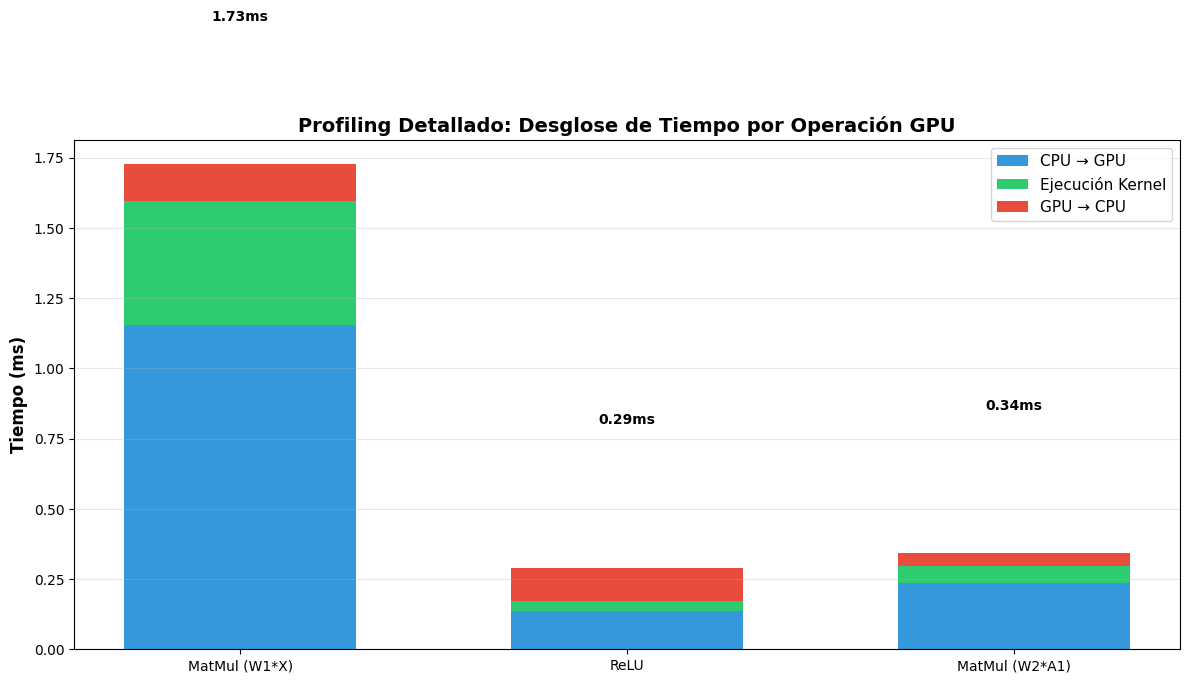

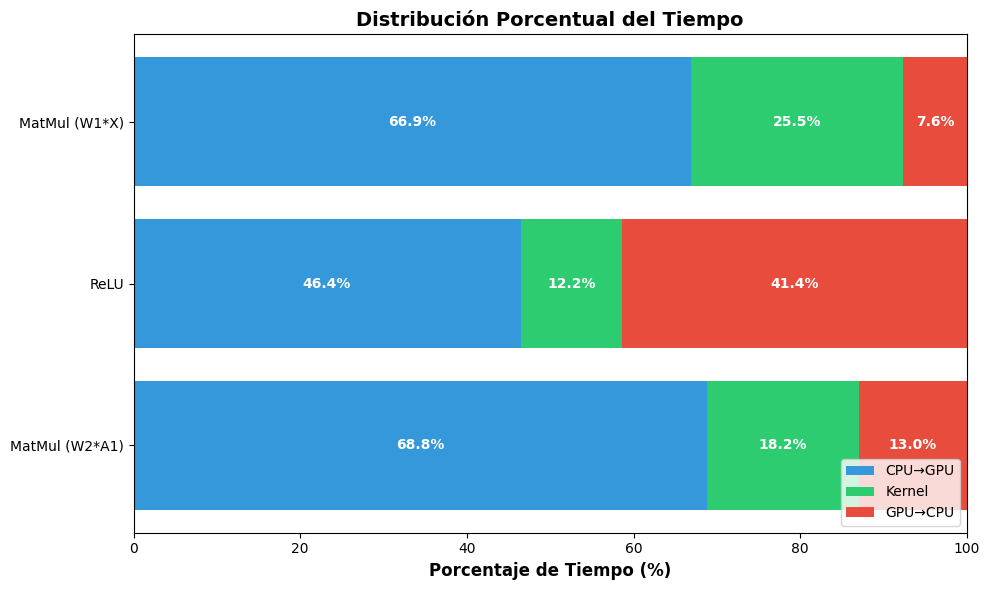

In [14]:
import time
import matplotlib.pyplot as plt

def detailed_gpu_profiling():
    """
    Profiling detallado mostrando:
    1. Transferencia CPU → GPU
    2. Ejecución del Kernel
    3. Transferencia GPU → CPU
    """
    print("\n=== PROFILING DETALLADO GPU ===")

    # Crear batch de prueba
    X_batch = X_train[:, :128].copy()
    batch_size = 128

    # Diccionario para almacenar tiempos
    profiling_data = {
        'Operación': [],
        'CPU→GPU (ms)': [],
        'Ejecución Kernel (ms)': [],
        'GPU→CPU (ms)': [],
        'Total (ms)': []
    }

    n_runs = 50  # Múltiples corridas para medición precisa

    print(f"Ejecutando {n_runs} iteraciones para cada operación...\n")

    # ========================================
    # 1. MATMUL (W1 * X)
    # ========================================
    h2d_times, kernel_times, d2h_times = [], [], []

    for _ in range(n_runs):
        # CPU → GPU
        start = time.perf_counter()
        W1_gpu = gpuarray.to_gpu(W1.astype(np.float32))
        X_gpu = gpuarray.to_gpu(X_batch.astype(np.float32))
        C_gpu = gpuarray.zeros((HIDDEN_SIZE, batch_size), dtype=np.float32)
        h2d_time = time.perf_counter() - start

        # Ejecución Kernel
        block_size = 16
        grid_x = (batch_size + block_size - 1) // block_size
        grid_y = (HIDDEN_SIZE + block_size - 1) // block_size

        start = time.perf_counter()
        matmul_gpu(
            W1_gpu, X_gpu, C_gpu,
            np.int32(HIDDEN_SIZE), np.int32(INPUT_SIZE), np.int32(batch_size),
            block=(block_size, block_size, 1),
            grid=(grid_x, grid_y)
        )
        cuda.Context.synchronize()  # Esperar a que termine
        kernel_time = time.perf_counter() - start

        # GPU → CPU
        start = time.perf_counter()
        result = C_gpu.get()
        d2h_time = time.perf_counter() - start

        h2d_times.append(h2d_time * 1000)
        kernel_times.append(kernel_time * 1000)
        d2h_times.append(d2h_time * 1000)

    profiling_data['Operación'].append('MatMul (W1*X)')
    profiling_data['CPU→GPU (ms)'].append(np.mean(h2d_times))
    profiling_data['Ejecución Kernel (ms)'].append(np.mean(kernel_times))
    profiling_data['GPU→CPU (ms)'].append(np.mean(d2h_times))
    profiling_data['Total (ms)'].append(np.mean(h2d_times) + np.mean(kernel_times) + np.mean(d2h_times))

    # ========================================
    # 2. ReLU
    # ========================================
    h2d_times, kernel_times, d2h_times = [], [], []

    Z_test = np.random.randn(HIDDEN_SIZE, batch_size).astype(np.float32)

    for _ in range(n_runs):
        # CPU → GPU
        start = time.perf_counter()
        Z_gpu = gpuarray.to_gpu(Z_test)
        h2d_time = time.perf_counter() - start

        # Ejecución Kernel
        size = Z_test.size
        block_size = 256
        grid_size = (size + block_size - 1) // block_size

        start = time.perf_counter()
        relu_gpu(Z_gpu, np.int32(size), block=(block_size, 1, 1), grid=(grid_size, 1))
        cuda.Context.synchronize()
        kernel_time = time.perf_counter() - start

        # GPU → CPU
        start = time.perf_counter()
        result = Z_gpu.get()
        d2h_time = time.perf_counter() - start

        h2d_times.append(h2d_time * 1000)
        kernel_times.append(kernel_time * 1000)
        d2h_times.append(d2h_time * 1000)

    profiling_data['Operación'].append('ReLU')
    profiling_data['CPU→GPU (ms)'].append(np.mean(h2d_times))
    profiling_data['Ejecución Kernel (ms)'].append(np.mean(kernel_times))
    profiling_data['GPU→CPU (ms)'].append(np.mean(d2h_times))
    profiling_data['Total (ms)'].append(np.mean(h2d_times) + np.mean(kernel_times) + np.mean(d2h_times))

    # ========================================
    # 3. MATMUL (W2 * A1)
    # ========================================
    h2d_times, kernel_times, d2h_times = [], [], []
    A1_test = np.random.randn(HIDDEN_SIZE, batch_size).astype(np.float32)

    for _ in range(n_runs):
        # CPU → GPU
        start = time.perf_counter()
        W2_gpu = gpuarray.to_gpu(W2.astype(np.float32))
        A1_gpu = gpuarray.to_gpu(A1_test)
        C_gpu = gpuarray.zeros((OUTPUT_SIZE, batch_size), dtype=np.float32)
        h2d_time = time.perf_counter() - start

        # Ejecución Kernel
        block_size = 16
        grid_x = (batch_size + block_size - 1) // block_size
        grid_y = (OUTPUT_SIZE + block_size - 1) // block_size

        start = time.perf_counter()
        matmul_gpu(
            W2_gpu, A1_gpu, C_gpu,
            np.int32(OUTPUT_SIZE), np.int32(HIDDEN_SIZE), np.int32(batch_size),
            block=(block_size, block_size, 1),
            grid=(grid_x, grid_y)
        )
        cuda.Context.synchronize()
        kernel_time = time.perf_counter() - start

        # GPU → CPU
        start = time.perf_counter()
        result = C_gpu.get()
        d2h_time = time.perf_counter() - start

        h2d_times.append(h2d_time * 1000)
        kernel_times.append(kernel_time * 1000)
        d2h_times.append(d2h_time * 1000)

    profiling_data['Operación'].append('MatMul (W2*A1)')
    profiling_data['CPU→GPU (ms)'].append(np.mean(h2d_times))
    profiling_data['Ejecución Kernel (ms)'].append(np.mean(kernel_times))
    profiling_data['GPU→CPU (ms)'].append(np.mean(d2h_times))
    profiling_data['Total (ms)'].append(np.mean(h2d_times) + np.mean(kernel_times) + np.mean(d2h_times))

    # ========================================
    # MOSTRAR TABLA
    # ========================================
    import pandas as pd
    df = pd.DataFrame(profiling_data)
    print("\n" + "="*80)
    print("TABLA DE PROFILING")
    print("="*80)
    print(df.to_string(index=False))
    print("="*80)

    # ========================================
    # GRÁFICA DE BARRAS APILADAS
    # ========================================
    fig, ax = plt.subplots(figsize=(12, 7))

    operations = profiling_data['Operación']
    h2d = profiling_data['CPU→GPU (ms)']
    kernel = profiling_data['Ejecución Kernel (ms)']
    d2h = profiling_data['GPU→CPU (ms)']

    x = np.arange(len(operations))
    width = 0.6

    # Barras apiladas
    p1 = ax.bar(x, h2d, width, label='CPU → GPU', color='#3498db')
    p2 = ax.bar(x, kernel, width, bottom=h2d, label='Ejecución Kernel', color='#2ecc71')
    p3 = ax.bar(x, d2h, width, bottom=np.array(h2d)+np.array(kernel), label='GPU → CPU', color='#e74c3c')

    ax.set_ylabel('Tiempo (ms)', fontsize=12, fontweight='bold')
    ax.set_title('Profiling Detallado: Desglose de Tiempo por Operación GPU', fontsize=14, fontweight='bold')
    ax.set_xticks(x)
    ax.set_xticklabels(operations)
    ax.legend(loc='upper right', fontsize=11)
    ax.grid(axis='y', alpha=0.3)

    # Añadir valores en las barras
    for i in range(len(operations)):
        total = h2d[i] + kernel[i] + d2h[i]
        ax.text(i, total + 0.5, f'{total:.2f}ms', ha='center', va='bottom', fontweight='bold')

    plt.tight_layout()
    plt.show()

    # ========================================
    # GRÁFICA DE PORCENTAJES
    # ========================================
    fig, ax = plt.subplots(figsize=(10, 6))

    for i, op in enumerate(operations):
        total = h2d[i] + kernel[i] + d2h[i]
        h2d_pct = (h2d[i] / total) * 100
        kernel_pct = (kernel[i] / total) * 100
        d2h_pct = (d2h[i] / total) * 100

        y_pos = len(operations) - i - 1

        ax.barh(y_pos, h2d_pct, color='#3498db', label='CPU→GPU' if i==0 else '')
        ax.barh(y_pos, kernel_pct, left=h2d_pct, color='#2ecc71', label='Kernel' if i==0 else '')
        ax.barh(y_pos, d2h_pct, left=h2d_pct+kernel_pct, color='#e74c3c', label='GPU→CPU' if i==0 else '')

        # Añadir porcentajes
        ax.text(h2d_pct/2, y_pos, f'{h2d_pct:.1f}%', ha='center', va='center', color='white', fontweight='bold')
        ax.text(h2d_pct + kernel_pct/2, y_pos, f'{kernel_pct:.1f}%', ha='center', va='center', color='white', fontweight='bold')
        ax.text(h2d_pct + kernel_pct + d2h_pct/2, y_pos, f'{d2h_pct:.1f}%', ha='center', va='center', color='white', fontweight='bold')

    ax.set_yticks(range(len(operations)))
    ax.set_yticklabels(operations[::-1])
    ax.set_xlabel('Porcentaje de Tiempo (%)', fontsize=12, fontweight='bold')
    ax.set_title('Distribución Porcentual del Tiempo', fontsize=14, fontweight='bold')
    ax.legend(loc='lower right')
    ax.set_xlim(0, 100)

    plt.tight_layout()
    plt.show()

    return profiling_data

# Ejecutar profiling
profiling_results = detailed_gpu_profiling()


ANÁLISIS COMPARATIVO: BATCH SIZE PEQUEÑO vs GRANDE

--- Probando Batch Size: 16 ---

=== INICIO ENTRENAMIENTO GPU (PyCUDA) ===
Arquitectura: 784 -> 512 -> 10
Batch size: 16, Learning rate: 0.01
Total batches por epoch: 625

Epoch 1/3 - Loss: 2.3319 - Acc: 10.68% - Tiempo: 3.60s
Epoch 2/3 - Loss: 2.3351 - Acc: 10.40% - Tiempo: 3.62s
Epoch 3/3 - Loss: 2.3555 - Acc: 9.95% - Tiempo: 4.05s

=== ENTRENAMIENTO COMPLETADO ===
Tiempo total: 11.27s
Tiempo promedio por epoch: 3.76s
  Tiempo total: 11.33s
  Tiempo por epoch: 3.78s
  Throughput: 2648 muestras/s
  Tiempo por muestra: 0.378 ms
  Ocupación GPU estimada: 100.0%
  Accuracy final: 9.95%

--- Probando Batch Size: 512 ---

=== INICIO ENTRENAMIENTO GPU (PyCUDA) ===
Arquitectura: 784 -> 512 -> 10
Batch size: 512, Learning rate: 0.01
Total batches por epoch: 19

Epoch 1/3 - Loss: 2.3647 - Acc: 10.12% - Tiempo: 0.29s
Epoch 2/3 - Loss: 2.3546 - Acc: 10.20% - Tiempo: 0.30s
Epoch 3/3 - Loss: 2.3456 - Acc: 10.32% - Tiempo: 0.30s

=== ENTRENAMIENT

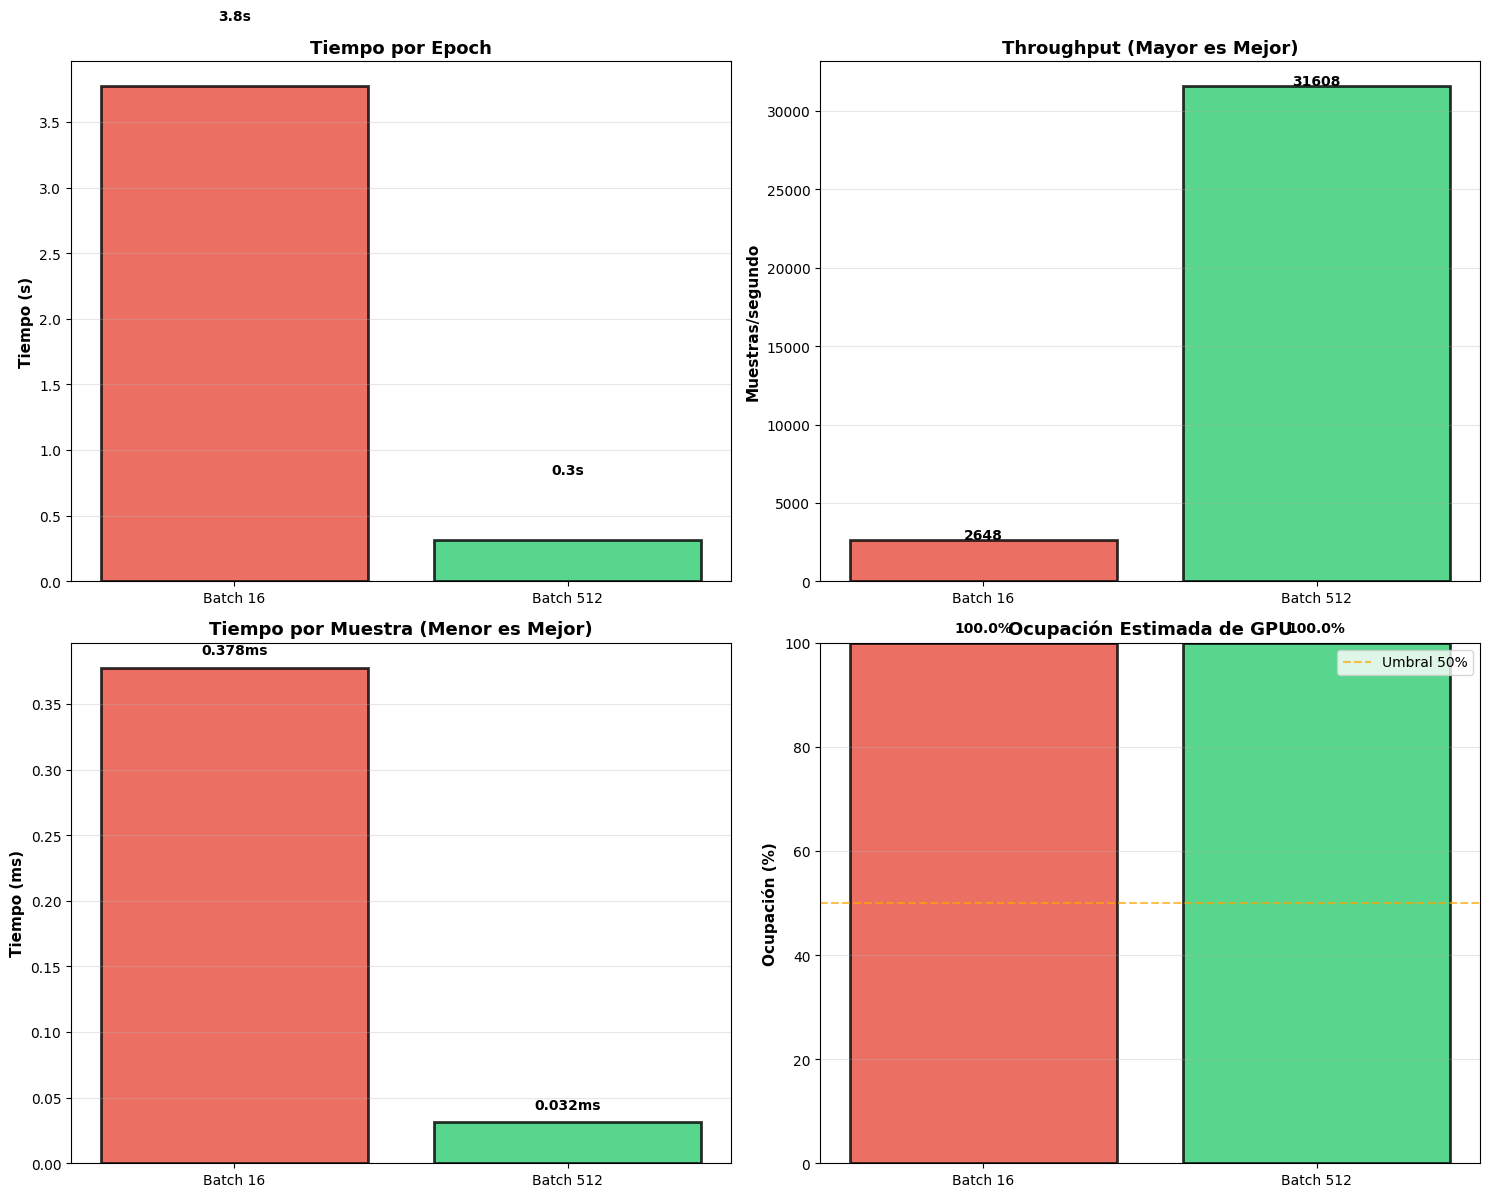

In [16]:
import pandas as pd

def batch_size_comparison():
    """
    Comparación detallada entre batch size pequeño (16) y grande (512)
    Explica por qué el rendimiento cambia dramáticamente
    """
    global W1, b1, W2, b2

    print("\n" + "="*80)
    print("ANÁLISIS COMPARATIVO: BATCH SIZE PEQUEÑO vs GRANDE")
    print("="*80)

    batch_configs = [
        {'size': 16, 'color': '#e74c3c', 'label': 'Pequeño (16)'},
        {'size': 512, 'color': '#2ecc71', 'label': 'Grande (512)'}
    ]

    results_comparison = []

    for config in batch_configs:
        bs = config['size']
        print(f"\n--- Probando Batch Size: {bs} ---")

        # Re-inicializar parámetros
        W1, b1, W2, b2 = init_params(INPUT_SIZE, HIDDEN_SIZE, OUTPUT_SIZE)

        # Usar subset de 10,000 muestras
        X_subset = X_train[:, :10000]
        Y_subset = Y_train[:10000]

        # Entrenar 3 epochs
        start_time = time.time()
        train_results = train_gpu(X_subset, Y_subset, epochs=3, batch_size=bs, lr=0.01)
        total_time = time.time() - start_time

        # Calcular métricas
        avg_epoch_time = total_time / 3
        samples_per_sec = 10000 / avg_epoch_time
        time_per_sample = (avg_epoch_time * 1000) / 10000  # ms por muestra

        # Calcular ocupación de GPU (aproximado)
        # GPU ocupancy = (threads utilizados) / (threads máximos)
        threads_per_block = 16 * 16  # 256 threads
        blocks_needed = ((bs + 15) // 16) * ((HIDDEN_SIZE + 15) // 16)
        threads_used = threads_per_block * blocks_needed

        # Supongamos GPU con 2048 CUDA cores (ajusta según tu GPU)
        gpu_cores = 2048
        occupancy = min(100, (threads_used / gpu_cores) * 100)

        results_comparison.append({
            'batch_size': bs,
            'total_time': total_time,
            'avg_epoch_time': avg_epoch_time,
            'samples_per_sec': samples_per_sec,
            'time_per_sample': time_per_sample,
            'occupancy': occupancy,
            'final_acc': train_results['accuracies'][-1] * 100
        })

        print(f"  Tiempo total: {total_time:.2f}s")
        print(f"  Tiempo por epoch: {avg_epoch_time:.2f}s")
        print(f"  Throughput: {samples_per_sec:.0f} muestras/s")
        print(f"  Tiempo por muestra: {time_per_sample:.3f} ms")
        print(f"  Ocupación GPU estimada: {occupancy:.1f}%")
        print(f"  Accuracy final: {train_results['accuracies'][-1]*100:.2f}%")

    # ========================================
    # TABLA COMPARATIVA
    # ========================================
    print("\n" + "="*80)
    print("TABLA COMPARATIVA")
    print("="*80)

    comparison_df = pd.DataFrame(results_comparison)
    print(comparison_df.to_string(index=False))

    # Calcular speedup
    speedup = results_comparison[0]['avg_epoch_time'] / results_comparison[1]['avg_epoch_time']
    throughput_ratio = results_comparison[1]['samples_per_sec'] / results_comparison[0]['samples_per_sec']

    print("\n" + "="*80)
    print("COMPARACIÓN DIRECTA")
    print("="*80)
    print(f"Speedup (grande vs pequeño): {speedup:.2f}x")
    print(f"Mejora en throughput: {throughput_ratio:.2f}x")
    print(f"Eficiencia relativa: {(throughput_ratio/speedup)*100:.1f}%")

    # ========================================
    # GRÁFICAS
    # ========================================
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 12))

    # Gráfica 1: Tiempo por Epoch
    ax1.bar(['Batch 16', 'Batch 512'],
            [r['avg_epoch_time'] for r in results_comparison],
            color=[batch_configs[0]['color'], batch_configs[1]['color']],
            alpha=0.8, edgecolor='black', linewidth=2)
    ax1.set_ylabel('Tiempo (s)', fontsize=11, fontweight='bold')
    ax1.set_title('Tiempo por Epoch', fontsize=13, fontweight='bold')
    ax1.grid(axis='y', alpha=0.3)
    for i, r in enumerate(results_comparison):
        ax1.text(i, r['avg_epoch_time'] + 0.5, f"{r['avg_epoch_time']:.1f}s",
                ha='center', fontweight='bold')

    # Gráfica 2: Throughput
    ax2.bar(['Batch 16', 'Batch 512'],
            [r['samples_per_sec'] for r in results_comparison],
            color=[batch_configs[0]['color'], batch_configs[1]['color']],
            alpha=0.8, edgecolor='black', linewidth=2)
    ax2.set_ylabel('Muestras/segundo', fontsize=11, fontweight='bold')
    ax2.set_title('Throughput (Mayor es Mejor)', fontsize=13, fontweight='bold')
    ax2.grid(axis='y', alpha=0.3)
    for i, r in enumerate(results_comparison):
        ax2.text(i, r['samples_per_sec'] + 50, f"{r['samples_per_sec']:.0f}",
                ha='center', fontweight='bold')

    # Gráfica 3: Tiempo por Muestra
    ax3.bar(['Batch 16', 'Batch 512'],
            [r['time_per_sample'] for r in results_comparison],
            color=[batch_configs[0]['color'], batch_configs[1]['color']],
            alpha=0.8, edgecolor='black', linewidth=2)
    ax3.set_ylabel('Tiempo (ms)', fontsize=11, fontweight='bold')
    ax3.set_title('Tiempo por Muestra (Menor es Mejor)', fontsize=13, fontweight='bold')
    ax3.grid(axis='y', alpha=0.3)
    for i, r in enumerate(results_comparison):
        ax3.text(i, r['time_per_sample'] + 0.01, f"{r['time_per_sample']:.3f}ms",
                ha='center', fontweight='bold')

    # Gráfica 4: Ocupación de GPU
    ax4.bar(['Batch 16', 'Batch 512'],
            [r['occupancy'] for r in results_comparison],
            color=[batch_configs[0]['color'], batch_configs[1]['color']],
            alpha=0.8, edgecolor='black', linewidth=2)
    ax4.set_ylabel('Ocupación (%)', fontsize=11, fontweight='bold')
    ax4.set_title('Ocupación Estimada de GPU', fontsize=13, fontweight='bold')
    ax4.set_ylim(0, 100)
    ax4.axhline(y=50, color='orange', linestyle='--', label='Umbral 50%', alpha=0.7)
    ax4.grid(axis='y', alpha=0.3)
    ax4.legend()
    for i, r in enumerate(results_comparison):
        ax4.text(i, r['occupancy'] + 2, f"{r['occupancy']:.1f}%",
                ha='center', fontweight='bold')

    plt.tight_layout()
    plt.show()

    return results_comparison

# Ejecutar análisis de batch size
batch_comparison = batch_size_comparison()